<a href="https://colab.research.google.com/github/va4756/big_RaeJung/blob/main/DeepLearning_pytorch_Okawa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 현재 Colab 환경에 클론
!git clone https://github.com/YutaroOgawa/pytorch_advanced.git

fatal: destination path 'pytorch_advanced' already exists and is not an empty directory.


In [4]:
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import torch
import torchvision
from torchvision import models, transforms

In [7]:
use_pretrained = True
net = models.vgg16(pretrained=use_pretrained)
net.eval()
print(net)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:03<00:00, 153MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
class BaseTransform():
    def __init__(self, resize, mean, std):
        self.base_transform = transforms.Compose([
            transforms.Resize(resize),
            transforms.CenterCrop(resize),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.base_transform(img)

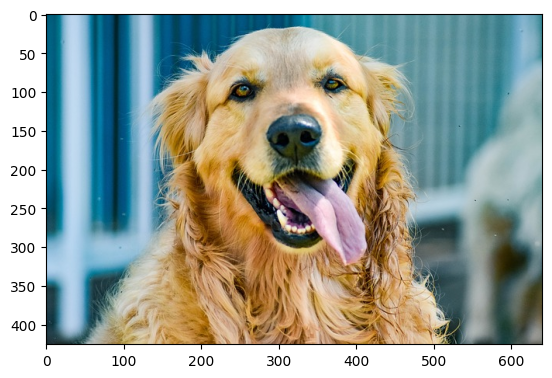

In [12]:
image_file_path = '/content/pytorch_advanced/1_image_classification/data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)

plt.imshow(img)
plt.show()

In [17]:
resize = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
transform = BaseTransform(resize, mean, std)
img_transformed = transform(img)

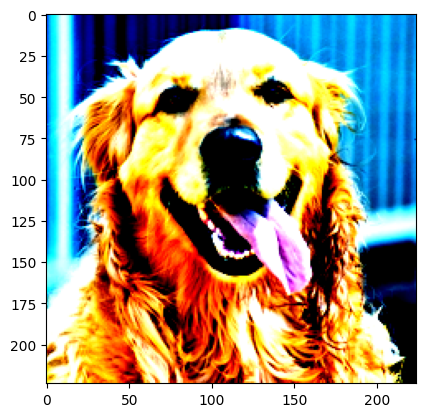

In [18]:
img_transformed = img_transformed.numpy().transpose((1,2,0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

In [20]:
import json
import urllib.request
import os

os.makedirs('data', exist_ok=True)

url = 'https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json'
urllib.request.urlretrieve(url, './data/imagenet_class_index.json')

ILSVRC_class_index = json.load(open('./data/imagenet_class_index.json', 'r'))

In [21]:
ILSVRC_class_index

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

In [22]:
class ILSVRCPredictor():
    def __init__(self, class_index):
        self.class_index = class_index

    def predict_max(self, out):
        maxId = np.argmax(out.detach().numpy())
        predicted_label_name = self.class_index[str(maxId)][1]

        return predicted_label_name

In [23]:
predictor = ILSVRCPredictor(ILSVRC_class_index)

In [24]:
image_file_path = '/content/pytorch_advanced/1_image_classification/data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)

In [25]:
transform = BaseTransform(resize, mean, std)
img_transformed = transform(img)
inputs = img_transformed.unsqueeze_(0)

In [26]:
out = net(inputs)
result = predictor.predict_max(out)
print(result)

golden_retriever
